# INSTALLING SOLAR PANELS

In this notebook we will explore the generation of energy of a system of solar panels and which could be the savings and costs of installing this system 

### Do the necessary imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

### Charge the electric consumption data 

In [2]:
humanitats_energy = pd.read_excel("Hourly Electrical Energy_01-01-2022_30-11-2022.xls")

humanitats_energy

,Date,Hour,L-Bibl.Humanitats (General) [kWh]
0,2022-01-01 00:00:00,2022-01-01 00:00:00,5.345714
1,2022-01-01 01:00:00,2022-01-01 01:00:00,4.640000
2,2022-01-01 02:00:00,2022-01-01 02:00:00,4.875000
3,2022-01-01 03:00:00,2022-01-01 03:00:00,5.425000
4,2022-01-01 04:00:00,2022-01-01 04:00:00,4.814286
...,...,...,...
8011,2022-11-30 19:00:00,2022-11-30 19:00:00,80.700000
8012,2022-11-30 20:00:00,2022-11-30 20:00:00,37.120000
8013,2022-11-30 21:00:00,2022-11-30 21:00:00,24.400000
8014,2022-11-30 22:00:00,2022-11-30 22:00:00,6.380000


### Tranform and visualize dataframe

In [3]:
tot = []
for x in humanitats_energy["Hour"]:
    pr = str(x)[-8:]
    pr1 = [i for i in pr if i != ':']
    
    pr2 = int("".join(pr1))
    tot.append(pr2/10000)

In [4]:
data_radiation = pd.read_csv("PVdata_converted.csv", sep=';')

In [5]:
ciencies_consum = pd.read_csv("Provided_energy_data//Consum_horari_electricitat_ciencies_biociencies_2018-2022.csv",sep = ";")
ciencies_consum

,Date,Hour,C Ciències Trafo 1 (General) [kWh] [C-Ciencies],C Ciències Trafo 2 (General) [kWh] [C-Ciencies]
0,01/01/2018,00:00,"153,87","98,13"
1,01/01/2018,01:00,"157,87","96,00"
2,01/01/2018,02:00,"158,27","97,87"
3,01/01/2018,03:00,"159,60","98,13"
4,01/01/2018,04:00,"156,27","96,13"
...,...,...,...,...
43819,31/12/2022,19:00,"128,00","84,00"
43820,31/12/2022,20:00,"128,00","82,00"
43821,31/12/2022,21:00,"124,00","84,00"
43822,31/12/2022,22:00,"124,00","82,00"


In [6]:
#In this cell we change the name of the third and forth column in order to work easily with them 
ciencies_consum.rename(columns={'C Ciències Trafo 1 (General) [kWh] [C-Ciencies]': 'trafo1', 'C Ciències Trafo 2 (General) [kWh] [C-Ciencies]': 'trafo2'}, inplace=True)

In [7]:
ciencies_consum["trafo1"] = ciencies_consum["trafo1"].str.replace(',', '.')
ciencies_consum["trafo1"] = ciencies_consum["trafo1"].astype(float)


In [8]:
ciencies_consum["trafo2"] = ciencies_consum["trafo2"].str.replace(',', '.')
ciencies_consum["trafo2"] = ciencies_consum["trafo2"].astype(float)

# Pick historical solar radiation data from the PVGIS API

In [9]:
#E_d: Average daily energy production from the given system (kWh/d)
#E_m: Average monthly energy production from the given system (kWh/mo)
#H(i)_d: Average daily sum of global irradiation per square meter received by the modules of the given system (kWh/m2/d)
#H(i)_m: Average monthly sum of global irradiation per square meter received by the modules of the given system (kWh/m2/mo)
#SD_m: Standard deviation of the monthly energy production due to year-to-year variation (kWh)
#PVGIS (c) European Union, 2001-2023

In [10]:
import requests
import csv

# Specify the location and time period for which you want to retrieve solar radiation data
name = "PVcalc"
lat = 40.7128 # latitude of location (in decimal degrees)
lon = -74.0060 # longitude of location (in decimal degrees)
start_year = 2020 # start year of time period
end_year = 2020 # end year of time period

# Construct the API URL
url = "https://re.jrc.ec.europa.eu/api/v5_1/tool_name?lat={lat}&lon={lon}&startyear={start_year}&endyear={end_year}&pvcalculation=1&outputformat=csv"

# Send a GET request to the API and retrieve the response
response = requests.get(url)

# Parse the JSON response into a Python dictionary
data = response.json()


In [11]:
import pvlib

In [12]:
radiation,meta,inputs = pvlib.iotools.get_pvgis_hourly(latitude = 41.501, longitude = 2.109, 
                               start=2018, 
                               end=2020, 
                               raddatabase="PVGIS-SARAH2", 
                               components=True, 
                               surface_tilt=45,
                               surface_azimuth=0,
                               outputformat='json',
                               usehorizon=True,
                               userhorizon=None,
                               pvcalculation=False,
                               peakpower=None,
                               pvtechchoice='crystSi',
                               mountingplace='free',
                               loss=0,
                               trackingtype=0,
                               optimal_surface_tilt=False,
                               optimalangles=False,
                               url='https://re.jrc.ec.europa.eu/api/v5_2/',
                               map_variables=True,
                               timeout=30)

## Plot some data extracted from the API

In [13]:
radiation

,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int
time,,,,,,,
2018-01-01 00:10:00+00:00,0.0,0.0,0.0,0.0,10.10,2.90,0
2018-01-01 01:10:00+00:00,0.0,0.0,0.0,0.0,10.09,3.31,0
2018-01-01 02:10:00+00:00,0.0,0.0,0.0,0.0,9.48,3.17,0
2018-01-01 03:10:00+00:00,0.0,0.0,0.0,0.0,8.97,3.45,0
2018-01-01 04:10:00+00:00,0.0,0.0,0.0,0.0,8.66,3.66,0
...,...,...,...,...,...,...,...
2020-12-31 19:10:00+00:00,0.0,0.0,0.0,0.0,8.68,3.86,0
2020-12-31 20:10:00+00:00,0.0,0.0,0.0,0.0,8.27,3.38,0
2020-12-31 21:10:00+00:00,0.0,0.0,0.0,0.0,7.91,3.10,0


In [14]:
meta

{'location': {'latitude': 41.501, 'longitude': 2.109, 'elevation': 126.0},
 'meteo_data': {'radiation_db': 'PVGIS-SARAH2',
  'meteo_db': 'ERA5',
  'year_min': 2018,
  'year_max': 2020,
  'use_horizon': True,
  'horizon_db': None,
  'horizon_data': 'DEM-calculated'},
 'mounting_system': {'fixed': {'slope': {'value': 45, 'optimal': False},
   'azimuth': {'value': 0, 'optimal': False},
   'type': 'free-standing'}},
 'pv_module': {'technology': None, 'peak_power': None, 'system_loss': None}}

# Define the functions to compute diferent scenarios for diferent solar systems 

### Function to calculate the energy consumed without any solar system installed

In [15]:
def calc_energy_consumed(consum,radiation,days = 2):
    '''
    This function returns a list with the sum of the energy consumed every x number of specified days
    '''
    energy_cons = []
    sum_day_cons = 0
    for i in range(len(radiation)):#
    
        x = i 
        hour_cien = consum["Hour"][x][0:2]
        day_cien = consum["Date"][x][0:2]
        month_cien = consum["Date"][x][3:5]
        year_cien = consum["Date"][x][6:11]
        
        hour = str(radiation['poa_direct'].index[i])[11:13]
        day = str(radiation['poa_direct'].index[i])[8:10]
        month = str(radiation['poa_direct'].index[i])[5:7]
        year = str(radiation['poa_direct'].index[i])[0:4]

        if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
            tot_cons = consum["trafo1"][x]+ consum["trafo2"][x]
            
            if i%(24*days) == 0 :
                energy_cons.append(sum_day_cons)
                sum_day_cons = 0
            else:
                sum_day_cons += tot_cons
                
        else:
            x = i-1 
            hour_cien = consum["Hour"][x][0:2]
            day_cien = consum["Date"][x][0:2]
            month_cien = consum["Date"][x][3:5]
            year_cien = consum["Date"][x][6:11]
            
            if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
                
                if i%(24*days) == 0 :
                    energy_cons.append(sum_day_cons)
                    sum_day_cons = 0
                else:
                    sum_day_cons += tot_cons
    return energy_cons

In [16]:
def calc_energy_consumed_cov(consum,radiation,days = 2):
    '''
    This function returns a list with the sum of the energy consumed every x number of specified days
    This funcition don't take into account the year 2020 to don't have noise because of covid
    '''
    energy_cons = []
    sum_day_cons = 0
    for i in range(len(radiation)):#
    
        x = i 
        hour_cien = consum["Hour"][x][0:2]
        day_cien = consum["Date"][x][0:2]
        month_cien = consum["Date"][x][3:5]
        year_cien = consum["Date"][x][6:11]
        
        hour = str(radiation['poa_direct'].index[i])[11:13]
        day = str(radiation['poa_direct'].index[i])[8:10]
        month = str(radiation['poa_direct'].index[i])[5:7]
        year = str(radiation['poa_direct'].index[i])[0:4]
        if year != '2020':
            if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                tot_cons = consum["trafo1"][x]+ consum["trafo2"][x]

                if i%(24*days) == 0 :
                    energy_cons.append(sum_day_cons)
                    sum_day_cons = 0
                else:
                    sum_day_cons += tot_cons

            else:
                x = i-1 
                hour_cien = consum["Hour"][x][0:2]
                day_cien = consum["Date"][x][0:2]
                month_cien = consum["Date"][x][3:5]
                year_cien = consum["Date"][x][6:11]

                if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                    tot_cons = consum["trafo1"][x] + consum["trafo2"][x]

                    if i%(24*days) == 0 :
                        energy_cons.append(sum_day_cons)
                        sum_day_cons = 0
                    else:
                        sum_day_cons += tot_cons
    return energy_cons

### Function to calculate the energy generated by a given solar system

In [17]:
def calc_energy_generated(consum, radiation, production_surface, system_efficiency,days = 2):
    '''
    This function returns a list with the sum of the energy extracted from the grid
    every x number of specified days, given some specified parameters of a solar installation
    '''
    energy_gen = []
    sum_day_gen = 0
    for i in range(len(radiation)):#
    
        x = i 
        hour_cien = consum["Hour"][x][0:2]
        day_cien = consum["Date"][x][0:2]
        month_cien = consum["Date"][x][3:5]
        year_cien = consum["Date"][x][6:11]
        
        hour = str(radiation['poa_direct'].index[i])[11:13]
        day = str(radiation['poa_direct'].index[i])[8:10]
        month = str(radiation['poa_direct'].index[i])[5:7]
        year = str(radiation['poa_direct'].index[i])[0:4]
        
            

        if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
            gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000
            
            if i%(24*days) == 0 :
                energy_gen.append(sum_day_gen)
                sum_day_gen = 0
            else:
                sum_day_gen += gen

        else:
            x = i-1 
            hour = str(radiation['poa_direct'].index[i])[11:13]
            day = str(radiation['poa_direct'].index[i])[8:10]
            month = str(radiation['poa_direct'].index[i])[5:7]
            year = str(radiation['poa_direct'].index[i])[0:4]

            hour_cien = ciencies_consum["Hour"][x][0:2]
            day_cien = ciencies_consum["Date"][x][0:2]
            month_cien = ciencies_consum["Date"][x][3:5]
            year_cien = ciencies_consum["Date"][x][6:11]
            
                
            if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000

                if i%(24*days) == 0 :
                    energy_gen.append(sum_day_gen)
                    sum_day_gen = 0
                else:
                    sum_day_gen += gen
    return energy_gen

In [18]:
def calc_energy_generated_cov(consum, radiation, production_surface, system_efficiency,days = 2):
    '''
    This function returns a list with the sum of the energy extracted from the grid
    every x number of specified days, given some specified parameters of a solar installation
    This funcition don't take into account the year 2020 to don't have noise because of covid
    '''
    energy_gen = []
    sum_day_gen = 0
    for i in range(len(radiation)):#
    
        x = i 
        hour_cien = consum["Hour"][x][0:2]
        day_cien = consum["Date"][x][0:2]
        month_cien = consum["Date"][x][3:5]
        year_cien = consum["Date"][x][6:11]
        
        hour = str(radiation['poa_direct'].index[i])[11:13]
        day = str(radiation['poa_direct'].index[i])[8:10]
        month = str(radiation['poa_direct'].index[i])[5:7]
        year = str(radiation['poa_direct'].index[i])[0:4]
        
        
        if year != '2020':
            
            if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000

                if i%(24*days) == 0 :
                    energy_gen.append(sum_day_gen)
                    sum_day_gen = 0
                else:
                    sum_day_gen += gen

            else:
                x = i-1 
                hour = str(radiation['poa_direct'].index[i])[11:13]
                day = str(radiation['poa_direct'].index[i])[8:10]
                month = str(radiation['poa_direct'].index[i])[5:7]
                year = str(radiation['poa_direct'].index[i])[0:4]

                hour_cien = ciencies_consum["Hour"][x][0:2]
                day_cien = ciencies_consum["Date"][x][0:2]
                month_cien = ciencies_consum["Date"][x][3:5]
                year_cien = ciencies_consum["Date"][x][6:11]
                
                if year != '2020':
                    
                    if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                        gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000

                        if i%(24*days) == 0 :
                            energy_gen.append(sum_day_gen)
                            sum_day_gen = 0
                        else:
                            sum_day_gen += gen
    return energy_gen

### Function to calculate the energy consumed from the grid with a solar system installed

In [19]:
def calc_energy_grid(consum, radiation, production_surface, system_efficiency,days = 2):
    '''
    This function returns a list with the sum of the energy extracted from the grid every x number of specified days
    '''
    energy_gr = []
    sum_day_gr = 0
    for i in range(len(radiation)):
        x = i 
        hour_cien = consum["Hour"][x][0:2]
        day_cien = consum["Date"][x][0:2]
        month_cien = consum["Date"][x][3:5]
        year_cien = consum["Date"][x][6:11]
        
        hour = str(radiation['poa_direct'].index[i])[11:13]
        day = str(radiation['poa_direct'].index[i])[8:10]
        month = str(radiation['poa_direct'].index[i])[5:7]
        year = str(radiation['poa_direct'].index[i])[0:4]
        
        if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
            tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
            gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000

            res = max(0,tot_cons - gen)

            if i%(24*days) == 0 :
                energy_gr.append(sum_day_gr)

                sum_day_gr = 0
            else:
                sum_day_gr+= res

        else:
            x = i-1 
            hour = str(radiation['poa_direct'].index[i])[11:13]
            day = str(radiation['poa_direct'].index[i])[8:10]
            month = str(radiation['poa_direct'].index[i])[5:7]
            year = str(radiation['poa_direct'].index[i])[0:4]

            hour_cien = ciencies_consum["Hour"][x][0:2]
            day_cien = ciencies_consum["Date"][x][0:2]
            month_cien = ciencies_consum["Date"][x][3:5]
            year_cien = ciencies_consum["Date"][x][6:11]
            
            if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
                gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000

                res = max(0,tot_cons - gen)
                if i%(24*days) == 0 :
                    sum_day_gr += res
                    energy_gr.append(sum_day_gr)
                    sum_day_gr = 0
                else:
                    sum_day_gr += res
    return energy_gr

In [20]:
def calc_energy_grid_cov(consum, radiation, production_surface, system_efficiency,days = 2):
    '''
    This function returns a list with the sum of the energy extracted from the grid every x number of specified days
    This funcition don't take into account the year 2020 to don't have noise because of covid
    '''
    energy_gr = []
    sum_day_gr = 0
    for i in range(len(radiation)):
        x = i 
        hour_cien = consum["Hour"][x][0:2]
        day_cien = consum["Date"][x][0:2]
        month_cien = consum["Date"][x][3:5]
        year_cien = consum["Date"][x][6:11]
        
        hour = str(radiation['poa_direct'].index[i])[11:13]
        day = str(radiation['poa_direct'].index[i])[8:10]
        month = str(radiation['poa_direct'].index[i])[5:7]
        year = str(radiation['poa_direct'].index[i])[0:4]
        if year != '2020':
            if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
                gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000

                res = max(0,tot_cons - gen)

                if i%(24*days) == 0 :
                    energy_gr.append(sum_day_gr)

                    sum_day_gr = 0
                else:
                    sum_day_gr+= res

            else:
                x = i-1 
                hour = str(radiation['poa_direct'].index[i])[11:13]
                day = str(radiation['poa_direct'].index[i])[8:10]
                month = str(radiation['poa_direct'].index[i])[5:7]
                year = str(radiation['poa_direct'].index[i])[0:4]

                hour_cien = ciencies_consum["Hour"][x][0:2]
                day_cien = ciencies_consum["Date"][x][0:2]
                month_cien = ciencies_consum["Date"][x][3:5]
                year_cien = ciencies_consum["Date"][x][6:11]
                if year != '2020':
                    if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                        tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
                        gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000

                        res = max(0,tot_cons - gen)
                        if i%(24*days) == 0 :
                            sum_day_gr += res
                            energy_gr.append(sum_day_gr)
                            sum_day_gr = 0
                        else:
                            sum_day_gr += res
    return energy_gr

In [21]:
def calc_energy_battery(consum, radiation, production_surface, system_efficiency,days = 2,battery_capacity = 60):
    energy_gr = []
    sum_day_gr = 0
    battery = 0
    battery_lis = []
    total_battery_save = 0 
    for i in range(len(radiation)):
        x = i 
        hour_cien = consum["Hour"][x][0:2]
        day_cien = consum["Date"][x][0:2]
        month_cien = consum["Date"][x][3:5]
        year_cien = consum["Date"][x][6:11]
        
        hour = str(radiation['poa_direct'].index[i])[11:13]
        day = str(radiation['poa_direct'].index[i])[8:10]
        month = str(radiation['poa_direct'].index[i])[5:7]
        year = str(radiation['poa_direct'].index[i])[0:4]
        
        if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
            tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
            gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000
            
            res = tot_cons - gen
            if res < 0:
                battery += abs(res)
                if battery > battery_capacity:
                    aux_bat = battery - battery_capacity
                    saved = res - aux_bat
                    battery = battery_capacity
                    total_battery_save += saved
                else:
                    
                    total_battery_save += abs(res)
                    
                
            else:
                if battery > 0:
                    new_res = battery - res
                    if new_res > 0:
                        battery = new_res
                        res = 0 
                    else:
                        res = abs(new_res)
                        
                    sum_day_gr += res
                else:
                    sum_day_gr += res
                    
                    
            
            if i%(24*days) == 0 :
                energy_gr.append(sum_day_gr)
                sum_day_gr = 0
                battery_lis.append(battery)
            
                
        else:
            x = i-1 
            hour = str(radiation['poa_direct'].index[i])[11:13]
            day = str(radiation['poa_direct'].index[i])[8:10]
            month = str(radiation['poa_direct'].index[i])[5:7]
            year = str(radiation['poa_direct'].index[i])[0:4]
            
            hour_cien = ciencies_consum["Hour"][x][0:2]
            day_cien = ciencies_consum["Date"][x][0:2]
            month_cien = ciencies_consum["Date"][x][3:5]
            year_cien = ciencies_consum["Date"][x][6:11]
            
            if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
                gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000
                res = tot_cons - gen
                if res < 0:
                    battery += abs(res)
                    if battery > battery_capacity:
                        aux_bat = battery - battery_capacity
                        saved = res - aux_bat
                        battery = battery_capacity
                        total_battery_save += saved
                    else:
                        total_battery_save += abs(res)
                else:
                    if battery > 0:
                        new_res = battery - res
                        if new_res > 0:
                            battery = new_res
                        else:
                            res = abs(new_res)
                        sum_day_gr += res 

                if i%(24*days) == 0 :
                    energy_gr.append(sum_day_gr)
                    sum_day_gr = 0
                    battery_lis.append(battery)
    return energy_gr, battery, total_battery_save

In [22]:
def calc_energy_battery_cov(consum, radiation, production_surface, system_efficiency,days = 2,battery_capacity = 60):
    energy_gr = []
    sum_day_gr = 0
    battery = 0
    battery_lis = []
    total_battery_save = 0 
    for i in range(len(radiation)):
        x = i 
        hour_cien = consum["Hour"][x][0:2]
        day_cien = consum["Date"][x][0:2]
        month_cien = consum["Date"][x][3:5]
        year_cien = consum["Date"][x][6:11]
        
        hour = str(radiation['poa_direct'].index[i])[11:13]
        day = str(radiation['poa_direct'].index[i])[8:10]
        month = str(radiation['poa_direct'].index[i])[5:7]
        year = str(radiation['poa_direct'].index[i])[0:4]
        if year != '2020':
            if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
                gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000

                res = tot_cons - gen
                if res < 0:
                    battery += abs(res)
                    if battery > battery_capacity:
                        aux_bat = battery - battery_capacity
                        saved = res - aux_bat
                        battery = battery_capacity
                        total_battery_save += saved
                    else:

                        total_battery_save += abs(res)


                else:
                    if battery > 0:
                        new_res = battery - res
                        if new_res > 0:
                            battery = new_res
                            res = 0 
                        else:
                            res = abs(new_res)

                        sum_day_gr += res
                    else:
                        sum_day_gr += res



                if i%(24*days) == 0 :
                    energy_gr.append(sum_day_gr)
                    sum_day_gr = 0
                    battery_lis.append(battery)


            else:
                x = i-1 
                hour = str(radiation['poa_direct'].index[i])[11:13]
                day = str(radiation['poa_direct'].index[i])[8:10]
                month = str(radiation['poa_direct'].index[i])[5:7]
                year = str(radiation['poa_direct'].index[i])[0:4]

                hour_cien = ciencies_consum["Hour"][x][0:2]
                day_cien = ciencies_consum["Date"][x][0:2]
                month_cien = ciencies_consum["Date"][x][3:5]
                year_cien = ciencies_consum["Date"][x][6:11]
                if year != '2020':
                    if hour_cien == hour and day_cien == day and month_cien == month and year_cien == year:
                        tot_cons = consum["trafo1"][x] + consum["trafo2"][x]
                        gen = (radiation["poa_direct"][i] * production_surface * system_efficiency)/1000
                        res = tot_cons - gen
                        if res < 0:
                            battery += abs(res)
                            if battery > battery_capacity:
                                aux_bat = battery - battery_capacity
                                saved = res - aux_bat
                                battery = battery_capacity
                                total_battery_save += saved
                            else:
                                total_battery_save += abs(res)
                        else:
                            if battery > 0:
                                new_res = battery - res
                                if new_res > 0:
                                    battery = new_res
                                else:
                                    res = abs(new_res)
                                sum_day_gr += res 

                        if i%(24*days) == 0 :
                            energy_gr.append(sum_day_gr)
                            sum_day_gr = 0
                            battery_lis.append(battery)
    return energy_gr, battery, total_battery_save

### Try the functions and do a plot 

In [23]:
generation_surface = 1500
efficiency = 0.2 # Average efficiency of solar systems 

In [24]:
consumption_cov = calc_energy_consumed_cov(ciencies_consum, radiation)

In [25]:
generation_cov = calc_energy_generated_cov(ciencies_consum, radiation, generation_surface, efficiency,days = 2)

In [26]:
grid_cov = calc_energy_grid_cov(ciencies_consum, radiation, generation_surface, efficiency,days = 2)

In [27]:
battery_cov,_,_ = calc_energy_battery_cov(ciencies_consum, radiation, generation_surface, efficiency,days = 2,battery_capacity = 60)

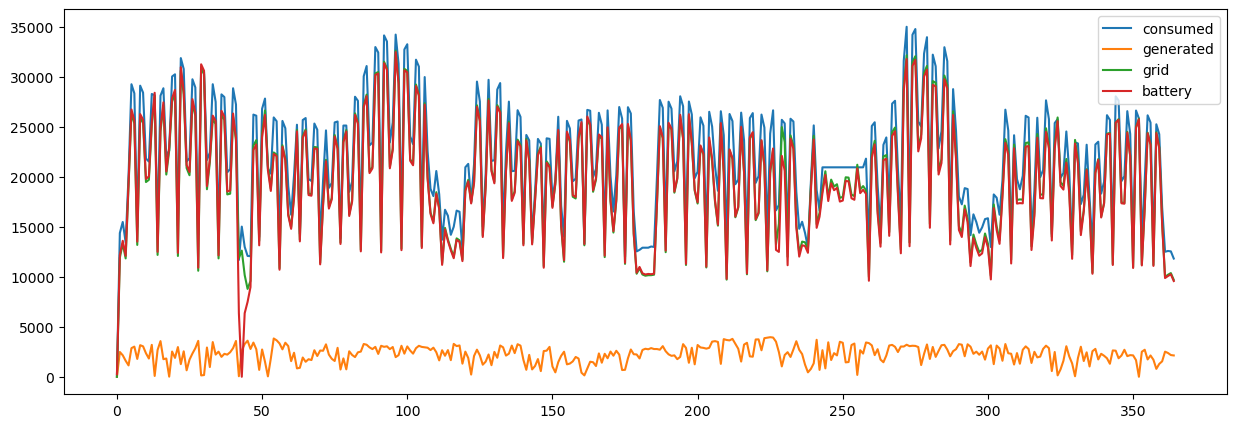

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(consumption_cov, label = 'consumed')
plt.plot(generation_cov, label = 'generated')
plt.plot(grid_cov, label = 'grid')
plt.plot(battery_cov,label = 'battery')
plt.legend()
plt.show()

### Smooth the plots to visualize them better 

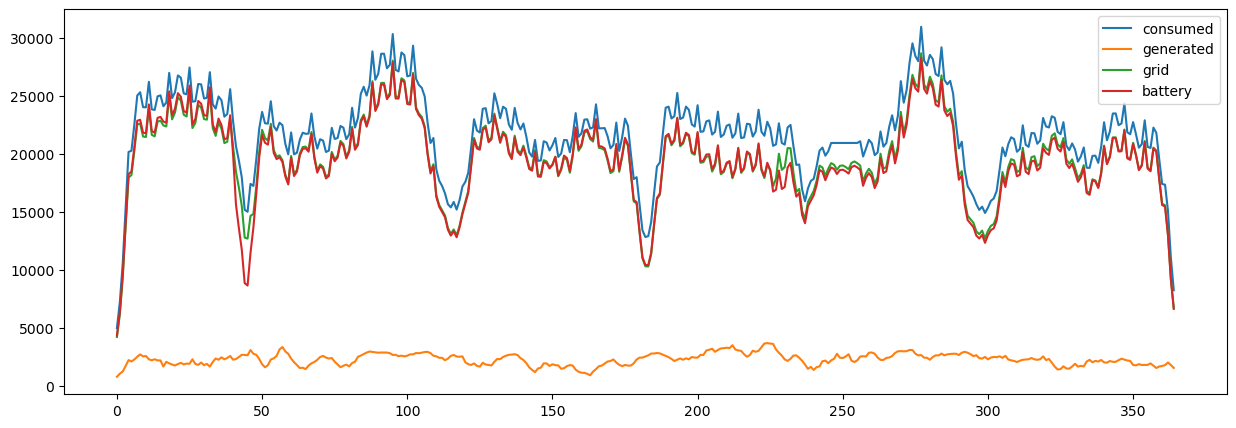

In [29]:
ksize = 3
avg_c = [sum(consumption_cov[max(i-ksize, 0):min(i+ksize, len(consumption_cov))])/(ksize*2) for i in range(len(consumption_cov))]
avg_r = [sum(generation_cov[max(i-ksize, 0):min(i+ksize, len(generation_cov))])/(ksize*2) for i in range(len(generation_cov))]
avg_gr = [sum(grid_cov[max(i-ksize, 0):min(i+ksize, len(grid_cov))])/(ksize*2) for i in range(len(grid_cov))]
avg_bt = [sum(battery_cov[max(i-ksize, 0):min(i+ksize, len(battery_cov))])/(ksize*2) for i in range(len(battery_cov))]
plt.figure(figsize=(15, 5))
plt.plot(avg_c, label = 'consumed')
plt.plot(avg_r, label = 'generated')
plt.plot(avg_gr, label = 'grid')
plt.plot(avg_bt,label = 'battery')
plt.legend()
plt.show()

### Calculate the average values for every year for the previously computed functions 

In [30]:
print(f'System with surface = {generation_surface} m2 and efficiency = {efficiency}:')
print(f'The average energy consumption every year is {sum(consumption_cov)/2000:.2f} MWh')
print(f'The average generation is {sum(generation_cov)/2000:.2f} MWh')
print(f'The average energy extracted from the grid every year is {sum(grid_cov)/2000:.2f} MWh') 
print(f'The average energy extracted from the grid every year with a battery is {sum(battery_cov)/2000:.2f} MWh') 

System with surface = 1500 m2 and efficiency = 0.2:
The average energy consumption every year is 3973.34 MWh
The average generation is 416.78 MWh
The average energy extracted from the grid every year is 3591.28 MWh
The average energy extracted from the grid every year with a battery is 3557.42 MWh


### Compute prices we will pay assuming a constant energy price

A way to compute the price of the installation component by component


In [31]:
def price_full_installation(production_surface, size_panels, space_bw_panels = 0.5, price_panel = 200, pay_workers = 20000, support_structure= 5000, solar_inversor = 12000):
   
    total_area_per_panel = size_panels + space_bw_panels ** 2

    panels = production_surface // total_area_per_panel

    price_panels = panels * price_panel

    final_cost = price_panels +  pay_workers + support_structure + solar_inversor 
    return final_cost
    



A way of computing the installation assuming a constant cost of intalling a KWp

In [32]:
def calc_system_cost(system_surface,pannel_surface,pannel_power,cost_KWp = 1000):
    num_pannels = (system_surface/pannel_surface)#m^2
    price = ((num_pannels*pannel_power)/1000)*cost_KWp#W
    return price

In [66]:
def compute_metrics(consum,radiation, system_efficiency,production_surface, future_price, pannel_surface,pannel_power,cost_KWp):
    energy_gr = calc_energy_grid(consum,radiation,production_surface,system_efficiency)
    energy_cons = calc_energy_consumed(consum,radiation)
    energy_gen = calc_energy_generated(consum,radiation,production_surface,system_efficiency)
    energy_gr_battery,_,_ = calc_energy_battery(consum,radiation,production_surface,system_efficiency)
    instalation_cost = price_full_installation(production_surface, pannel_surface)
    
    energy_cost = sum(energy_cons)/1000
    print(f'System with surface={production_surface} and efficiency = {system_efficiency} and future price = {future_price}:')
    print(f'The average year energy cost without any system is {energy_cost/3:.2f} MWh and {(energy_cost/3)*future_price:.2f}€ ')
    energy_sist = sum(energy_gr)/1000#*future_price
    print(f'The average year energy cost with the system is {(energy_sist/3):.2f} MWh and {(energy_sist/3)*future_price:.2f}€')
    energy_gr_bat = sum(energy_gr_battery)/1000#*future_price
    print(f'The average year energy cost with the system is {energy_gr_bat/3:.2f} MWh and {(energy_gr_bat/3)*future_price:.2f}€')
    saved_energy = (sum(energy_cons)-sum(energy_gr))/1000
    print(f'The energy saved with the system is {saved_energy/3:.2f} MWh and {(saved_energy/3)*future_price:.2f}€')
    saved_money = (saved_energy)*future_price
    print(f'The average year energy cost saved with the system is {saved_money/3:.2f}€')
    print(f'The system cost will be {instalation_cost:.2f} and will be amortized in {instalation_cost/(saved_money/3):.2f} years')
    percentage_produced = saved_energy / (sum(energy_cons)/1000)
    print(f'The percentage of energy saved with our system {percentage_produced:.2f}')
    print("----------------------------------------------------------------------")
    return energy_cost,saved_energy, saved_money, percentage_produced,energy_sist, energy_gr_bat
    

In [ ]:
def print_energy_cons(consum,radiation):
    ener_cons = calc_energy_consumed(consum,radiation)
    print(f'System with surface={generation_surface} and efficiency = {efficiency}:')
    print(f'The average year energy cost without any system is {(sum(ener_cons)/3000):.2f} MWh')
    return ener_cons

In [ ]:
def print_energy_grid(consum,radiation,production_surface,system_efficiency):
    energy_grid = calc_energy_grid(consum, radiation, production_surface, system_efficiency,days = 2)
    energy_gr = sum(energy_grid)/1000#*future_price
    print(f'The average year energy cost with the system is {(energy_gr/3):.2f} MWh')
    return energy_grid

In [ ]:
def print_energy_battery(consum,radiation,production_surface,system_efficiency):
    energy_bat,_,_ = calc_energy_battery(consum,radiation,production_surface,system_efficiency)
    print(f'The average year energy cost with the system is {(sum(energy_bat)/3000):.2f} euros')
    return energy_bat

In [61]:
s = print_energy_cons(ciencies_consum,radiation)

System with surface=1500 and efficiency = 0.2:
The average year energy cost without any system is 3654.05 MWh


In [62]:
gr = print_energy_grid(ciencies_consum,radiation,1000,0.2)

The average year energy cost with the system is 3412.26 MWh


In [63]:
bt = print_energy_battery(ciencies_consum,radiation, 1000,0.2)

The average year energy cost with the system is 3405.68 euros


### Compute all the combinations of some given assumptions 

In [67]:
lis_syst_efficiency = [0.15,0.2]
lis_future_price = [45,60,75]# Prices got from OMIP webpage(https://www.omip.pt/es)
surfaces = [1000,1500,2000,3000]
pannel_surface = 2
pannel_power = 400 # Average production of a solar panel
cost_KWp = 1000 #Cost get from some already done installations at the UAB(https://www.uab.cat/web/sala-de-prensa/detalle-noticia/la-uab-impulsa-las-energias-renovables-con-la-instalacion-de-placas-solares-1345830290069.html?detid=1345857540863)
costs = []
saves_ener = []
saves_money = []
prod_percentage = []
grid_energies = []
bat_energies = []
for production_surface in surfaces:
    for eff in lis_syst_efficiency:
        for future in lis_future_price:
            ener_cost, energy_saved, money_saved, percentage_produced, energy_grid,energy_gr_bat = compute_metrics(ciencies_consum,radiation, eff,production_surface, future,pannel_surface,pannel_power,cost_KWp)
            costs.append(ener_cost)
            saves_ener.append(energy_saved)
            saves_money.append(money_saved)
            prod_percentage.append(percentage_produced)
            grid_energies.append(energy_grid)
            bat_energies.append(energy_gr_bat)
        

System with surface=1000 and efficiency = 0.15 and future price = 45:
The average year energy cost without any system is 3654.05 MWh and 164432.37€ 
The average year energy cost with the system is 3480.69 MWh and 156630.83€
The average year energy cost with the system is 3353.27 MWh and 150897.10€
The energy saved with the system is 173.37 MWh and 7801.54€
The average year energy cost saved with the system is 7801.54€
The system cost will be 125800.00 and will be amortized in 16.13 years
The percentage of energy saved with our system 0.05
----------------------------------------------------------------------
System with surface=1000 and efficiency = 0.15 and future price = 60:
The average year energy cost without any system is 3654.05 MWh and 219243.16€ 
The average year energy cost with the system is 3480.69 MWh and 208841.11€
The average year energy cost with the system is 3353.27 MWh and 201196.14€
The energy saved with the system is 173.37 MWh and 10402.05€
The average year energy 

### Do a barplot to compare between systems 

In [ ]:
plt.bar(range(len(costs)),costs,color= "r",label = "NO sistem")
plt.bar(range(len(grid_energies)), grid_energies,color= "yellow", label = "Solar panels")
plt.bar(range(len(bat_energies)),bat_energies, color = "green", label = "Battery")

plt.legend()

plt.title("Yearly Energy generation")
plt.show()

### Do a final plot of the best option for the whole datset

In [ ]:
generation_surface = 1500
efficiency = 0.2

In [ ]:
consumption = calc_energy_consumed_cov(ciencies_consum, radiation)

In [ ]:
generation = calc_energy_generated_cov(ciencies_consum, radiation, generation_surface, efficiency,days = 2)

In [ ]:
grid = calc_energy_grid_cov(ciencies_consum, radiation, generation_surface, efficiency,days = 2)

In [ ]:
battery,_,_ = calc_energy_battery_cov(ciencies_consum, radiation, generation_surface, efficiency,days = 2,battery_capacity = 60)

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(consumption, label = 'consumed')
plt.plot(generation, label = 'generated')
plt.plot(grid, label = 'grid')
plt.plot(battery,label = 'battery')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
ksize = 3
avg_energy_cons = [sum(consumption[max(i-ksize, 0):min(i+ksize, len(consumption))])/(ksize*2) for i in range(len(consumption))]
avg_energy_gen = [sum(generation[max(i-ksize, 0):min(i+ksize, len(generation))])/(ksize*2) for i in range(len(generation))]
avg_energy_gr = [sum(grid[max(i-ksize, 0):min(i+ksize, len(grid))])/(ksize*2) for i in range(len(grid))]
avg_ener_bat = [sum(battery[max(i-ksize, 0):min(i+ksize, len(battery))])/(ksize*2) for i in range(len(battery))]

plt.plot(avg_energy_cons,label='consumed')
plt.plot(avg_energy_gen,label='generated')
plt.plot(avg_energy_gr, label = 'grid')
plt.plot(avg_ener_bat, label = 'bat')
plt.legend()
plt.show()